In [1]:

from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as CS
import os,datetime,sys,fnmatch
from mpl_toolkits import basemap
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from pyhdf.SD import SD, SDC
import os
import seaborn as sns
from matplotlib.patches import Rectangle

In [2]:
# simple plotting function
def plot_2D_global(lons,lats,data_2D,
                   data_name=None,
                   levels=20,
                   plot_type='normal',
                   vmin=0, vmax=0,
                   cmap='rainbow',
                   label=''
                   ):
    
    mapproj = Basemap(projection='cyl',
                llcrnrlat=-90, #lats.min(),
                llcrnrlon=lons.min(),
                urcrnrlat= 90, #lats.max(),
                urcrnrlon= lons.max())
    
    lonall, latall = mapproj.makegrid(lons.size, lats.size)
    lonproj, latproj = mapproj(lonall, latall)
    
    latlines = np.arange(latall.min(),latall.max()+1,15)
    lonlines = np.arange(lonall.min(),lonall.max()+1,45)
    
    if plot_type =='normal':
        ctr = mapproj.contourf(lonproj, latproj,data_2D,
                           vmin = vmin,
                           vmax = vmax,
                           levels = levels,
                           cmap   = cmap)
        
    elif plot_type == 'difference':
        ctr = mapproj.contourf(lonproj, latproj,data_2D,
                           vmin = vmin,
                           vmax = vmax,
                           levels = levels,
                           cmap   = cmap,
                           cbar_kwargs={"ticks": levels})
        plt.clim(vmin,vmax)
        
    
    
    plt.title(data_name)
    
    mapproj.drawcoastlines()
    mapproj.drawparallels(latlines, labels=[1,0,0,0])
    mapproj.drawmeridians(lonlines, labels=[0,0,0,1])
    
    mapproj.colorbar(ctr,"bottom", size="5%",pad = '20%', label=label)
    
    figname = data_name+'.png'
            
    #plt.savefig('Results/'+figname,dpi=200)
    
    #plt.show()

In [7]:
# read CESM and CERES data

def read_data(data_type,var_name):
    data_dir = '//umbc/xfs1/zzbatmos/common/Data/'
    noaa_data_dir = "//umbc/xfs1/cybertrn/cybertraining2020/team3/research/cmip6/src/noaa-data/"
    
    # CESM
    
    if data_type == 'cesm':
        prefix = 'CMIP/CMIP6/CESM2.1_run_f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001.cam.h0.'
        suffix = '.195001-201412.nc'
        ncfile   =  data_dir + prefix + var_name + suffix
        
        # define the class for reading 2D (lat-lon) cesm data
        class cesm_data_2D(object):
            def __init__(self,fn,var):   
                dataset = Dataset(fn)
                self.name = var
                self.lons = dataset.variables['lon'][:]
                self.lats = dataset.variables['lat'][:]
                self.time = dataset.variables['time'][-144:]
                self.date = dataset.variables['date'][-144:]
                self.data = dataset.variables[var][-144:,:,:]
                
        data = cesm_data_2D(ncfile,var_name)
        
    elif data_type == 'ceres':
        prefix = 'CERES/CERES_EBAF-TOA_Edition4.0_200003-201701.nc'
        ncfile = data_dir + prefix
        
        # define the class for reading 2D (lat-lon) ceres data
        class ceres_data_2D(object):
            def __init__(self,fn,var):   
                dataset = Dataset(fn)
                self.name = var
                self.lons = dataset.variables['lon'][:]
                self.lats = dataset.variables['lat'][:]
                self.time = dataset.variables['time'][34:178]
                self.data = dataset.variables[var][34:178:,:,:]
                
        data = ceres_data_2D(ncfile,var_name)

    elif data_type == 'noaa':
        suffix = '_CFmon_GFDL-CM4_amip_r1i1p1f1_gr1_200901-201412.nc'
        ncfile = noaa_data_dir + var_name + suffix
        
        # define the class for reading 2D (lat-lon) ceres data
        class noaa_data_2D(object):
            def __init__(self,fn,var):   
                dataset = Dataset(fn)
                self.name = var
                self.lons = dataset.variables['lon'][:]
                self.lats = dataset.variables['lat'][:]
                self.time = dataset.variables['time'][-144:]
                self.data = dataset.variables[var][-144:,:,:]
                
        data = noaa_data_2D(ncfile,var_name)
    return data

In [8]:
# CESM using MODIS simulated values

CLHMODIS_data = read_data(data_type='cesm',var_name='CLHMODIS') #MODIS High Level Cloud Fraction
CLHMODIS_mean = CLHMODIS_data.data.mean(axis=0)

CLMMODIS_data = read_data(data_type='cesm',var_name='CLMMODIS') #MODIS Mid Level Cloud Fraction
CLMMODIS_mean = CLMMODIS_data.data.mean(axis=0)

CLLMODIS_data = read_data(data_type='cesm',var_name='CLLMODIS') #MODIS Low Level Cloud Fraction
CLLMODIS_mean = CLLMODIS_data.data.mean(axis=0)

CLTMODIS_data = read_data(data_type='cesm',var_name='CLTMODIS') # MODIS total cloud fraction
CLTMODIS_mean = CLTMODIS_data.data.mean(axis=0)

# Radiation values

FSNTOAC_data = read_data(data_type='cesm',var_name='FSNTOAC') # Clearsky net solar flux at top of atmosphere
FSNTOAC_mean = FSNTOAC_data.data.mean(axis=0)
FSNTOA_data = read_data(data_type='cesm',var_name='FSNTOA') # Net solar flux at top of atmosphere (all sky)
FSNTOA_mean = FSNTOA_data.data.mean(axis=0)
FSUTOA_data = read_data(data_type='cesm',var_name='FSUTOA') # Upwellingsolar flux at top of atmosphere (all sky)
FSUTOA_mean = FSUTOA_data.data.mean(axis=0)

#Direct model output

CLDLOW_data = read_data(data_type='cesm',var_name='CLDLOW') # Vertically integrated low cloud fraction
CLDLOW_mean = CLDLOW_data.data.mean(axis=0)
CLDMED_data = read_data(data_type='cesm',var_name='CLDMED') # Vertically integrated mid cloud fraction
CLDMED_mean = CLDMED_data.data.mean(axis=0)
CLDHGH_data = read_data(data_type='cesm',var_name='CLDHGH') # Vertically integrated high cloud fraction
CLDHGH_mean = CLDHGH_data.data.mean(axis=0)



In [9]:
# noaa CALIPSO Percentage High Level Cloud
clhcalipso_data = read_data(data_type='noaa',var_name='clhcalipso') # 
clhcalipso_mean = clhcalipso_data.data.mean(axis=0)

# noaa CALIPSO Percentage low Level Cloud
cllcalipso_data = read_data(data_type='noaa',var_name='cllcalipso') # 
cllcalipso_mean = cllcalipso_data.data.mean(axis=0)

# noaa CALIPSO Percentage total Level Cloud
cltcalipso_data = read_data(data_type='noaa',var_name='cltcalipso') # 
cltcalipso_mean = cltcalipso_data.data.mean(axis=0)

In [10]:
#CERES TOA

#SW
solar_mon_data = read_data(data_type='ceres', var_name = 'solar_mon') # solar_mon

toa_sw_data = read_data(data_type='ceres',var_name='toa_sw_all_mon') # TOA Shortwave Flux - All-Sky
net_sw_toa = solar_mon_data.data.mean(axis=0) - toa_sw_data.data.mean(axis=0)

toa_sw_clr_data = read_data(data_type='ceres',var_name='toa_sw_clr_mon') # TOA Shortwave Flux - Clear-Sky
net_sw_toa_clr = solar_mon_data.data.mean(axis=0) - toa_sw_clr_data.data.mean(axis=0)

/umbc/xfs1/cybertrn/common/Softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
/umbc/xfs1/cybertrn/common/Softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
/umbc/xfs1/cybertrn/common/Softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
/umbc/xfs1/cybertrn/common/Softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
/umbc/xfs1/cybertrn/common/Softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
/umbc/xfs1/cybertrn/commo

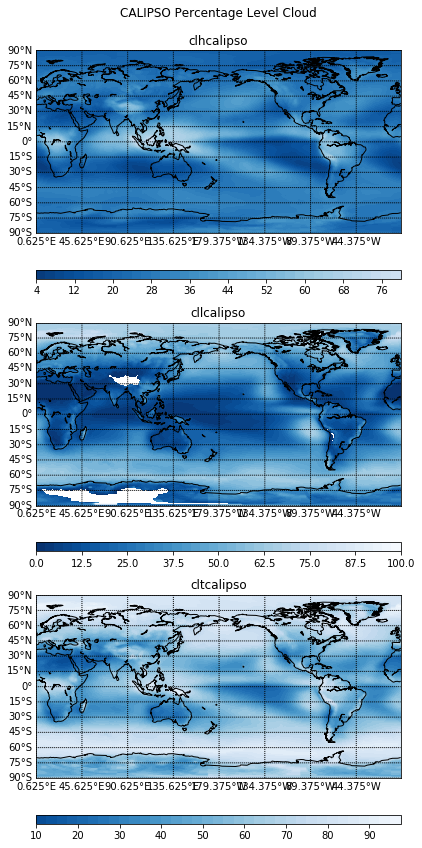

In [11]:
# Plot noaa CALIPSO Percentage Level Cloud
# plot_2D_global(lons+180,lats,np.flipud(MODIS_low_CF*100), data_name = 'MODIS_low_CF \n (Mean=%.4g)' %np.mean(np.flipud(MODIS_low_CF*100)), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')

plt.figure(figsize=(11,11.5))
plt.subplot(311)
plot_2D_global(clhcalipso_data.lons,clhcalipso_data.lats,clhcalipso_mean, data_name = 'clhcalipso', levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(312)
plot_2D_global(cllcalipso_data.lons,cllcalipso_data.lats,cllcalipso_mean, data_name = 'cllcalipso', levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(313)
plot_2D_global(cltcalipso_data.lons,cltcalipso_data.lats,cltcalipso_mean, data_name = 'cltcalipso', levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')

# lonout, latout = np.meshgrid(toa_sw_data.lons, toa_sw_data.lats)

# FSNTOA_interp = basemap.interp(FSNTOA_mean,FSNTOA_data.lons, FSNTOA_data.lats, lonout, latout)
# plt.subplot(313)
# plot_2D_global(toa_sw_data.lons,toa_sw_data.lats,(FSNTOA_interp-net_sw_toa), data_name = 'CESM(TOA)-CERES(TOA)', levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='bwr')

# plt.subplots_adjust(hspace=0)
plt.suptitle('CALIPSO Percentage Level Cloud', y=1.02)
plt.tight_layout()
#plt.savefig('./Results/New/Global maps/Radiation/Net SW All sky.png')
plt.show()


/umbc/xfs1/cybertrn/common/Softwares/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'cbar_kwargs'
  s)


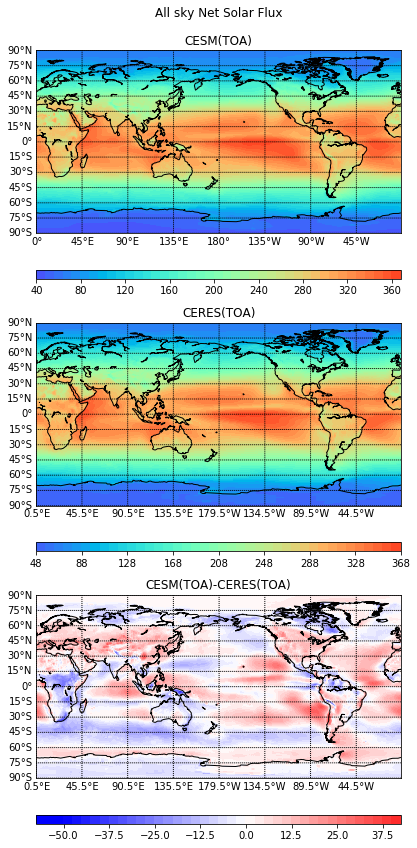

In [25]:
# SW CESM(TOA), CESM(TOM), CERES(TOA) and bias plots for all sky

plt.figure(figsize=(11,11.5))
plt.subplot(311)
plot_2D_global(FSNTOA_data.lons,FSNTOA_data.lats,FSNTOA_mean, data_name = 'CESM(TOA)', levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(312)
plot_2D_global(toa_sw_data.lons,toa_sw_data.lats,net_sw_toa, data_name = 'CERES(TOA)', levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')

lonout, latout = np.meshgrid(toa_sw_data.lons, toa_sw_data.lats)

FSNTOA_interp = basemap.interp(FSNTOA_mean,FSNTOA_data.lons, FSNTOA_data.lats, lonout, latout)
plt.subplot(313)
plot_2D_global(toa_sw_data.lons,toa_sw_data.lats,(FSNTOA_interp-net_sw_toa), data_name = 'CESM(TOA)-CERES(TOA)', levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='bwr')

# plt.subplots_adjust(hspace=0)
plt.suptitle('All sky Net Solar Flux', y=1.02)
plt.tight_layout()
#plt.savefig('./Results/New/Global maps/Radiation/Net SW All sky.png')
plt.show()

In [ ]:
modis_dir = '/umbc/xfs1/zzbatmos/common/Data/MODIS/6/MYD08_M3/'

Cloud_Fraction_Mean_Mean_array = np.array([])
Cloud_Top_Pressure_Histogram_Counts_array = np.array([])
Cloud_Top_Pressure_Mean_Mean_array = np.array([])

n=0      
for root, dirs, files in os.walk('/umbc/xfs1/zzbatmos/common/Data/MODIS/6/MYD08_M3/'):
    #print (dirs)
    if root == ("/umbc/xfs1/zzbatmos/common/Data/MODIS/6/MYD08_M3/2014/backup"):
        continue
    else:
        for name in files:
            if not name.startswith("MYD08_M3.A2002"):
                if (name.endswith(".hdf")):
                    #print (name)
                    year = name[10:14]
                    modis_file_name = modis_dir+year+'/'+name
                    n=n+1
                    modis_file = SD(modis_file_name, SDC.READ)
                    modis_file_data = modis_file.datasets()
                    #cloud fraction
                    Cloud_Fraction_Mean_Mean_file = modis_file.select('Cloud_Fraction_Mean_Mean')
                    Cloud_Fraction_Mean_Mean_file_data = Cloud_Fraction_Mean_Mean_file.get()
                    Cloud_Fraction_Mean_Mean_array = np.append(Cloud_Fraction_Mean_Mean_array,Cloud_Fraction_Mean_Mean_file_data)
                    #cloud top pressure histogram
                    Cloud_Top_Pressure_Histogram_Counts_file = modis_file.select('Cloud_Top_Pressure_Histogram_Counts')
                    Cloud_Top_Pressure_Histogram_Counts_file_data = Cloud_Top_Pressure_Histogram_Counts_file.get()
                    Cloud_Top_Pressure_Histogram_Counts_array = np.append(Cloud_Top_Pressure_Histogram_Counts_array,Cloud_Top_Pressure_Histogram_Counts_file_data)
                    #cloud top pressure
                    Cloud_Top_Pressure_Mean_Mean_file = modis_file.select('Cloud_Top_Pressure_Mean_Mean')
                    Cloud_Top_Pressure_Mean_Mean_file_data = Cloud_Top_Pressure_Mean_Mean_file.get()
                    Cloud_Top_Pressure_Mean_Mean_array = np.append(Cloud_Top_Pressure_Mean_Mean_array,Cloud_Top_Pressure_Mean_Mean_file_data)
                    
                    
print (n)
Cloud_Fraction_Mean_Mean_array = np.reshape(Cloud_Fraction_Mean_Mean_array,(144,180,360))
Cloud_Top_Pressure_Mean_Mean_array = np.reshape(Cloud_Top_Pressure_Mean_Mean_array,(144,180,360))
Cloud_Top_Pressure_Histogram_Counts_array = np.reshape(Cloud_Top_Pressure_Histogram_Counts_array,(144,10,180,360))

In [8]:
lons = range(0,360)
lons = np.array(lons)
lats = range(-90,90)
lats = np.array(lats)

In [9]:
def removeFillValue(modisdata):
    for i in range(180):
        for j in range(360):
            if modisdata[i,j]<=FillValue:
                modisdata[i,j]=None
    return modisdata

# Correcting MODIS cloud fraction
print ('MODIS CF')
scale1 = 9.999999747378752E-5
FillValue = -9999

for a in range(len(Cloud_Fraction_Mean_Mean_array)):
    removeFillValue(Cloud_Fraction_Mean_Mean_array[a])
    

Cloud_Fraction_Mean_Mean = np.nanmean(Cloud_Fraction_Mean_Mean_array,axis=0)
Cloud_Fraction_Mean_Mean = Cloud_Fraction_Mean_Mean*scale1
print (np.shape(Cloud_Fraction_Mean_Mean))
print (np.nanmin(Cloud_Fraction_Mean_Mean))
print (np.nanmax(Cloud_Fraction_Mean_Mean))


# Correcting MODIS cloud top pressure histogram counts
print ('MODIS cloud top pressure histogram counts')
scale2 = 1
FillValue = -9999

def removeFillValue2(modisdata):
    for k in range(10):
        for i in range(180):
            for j in range(360):
                if modisdata[k,i,j]<=FillValue:
                    modisdata[k,i,j]=None
    return modisdata

for a in range(len(Cloud_Top_Pressure_Histogram_Counts_array)):
    removeFillValue2(Cloud_Top_Pressure_Histogram_Counts_array[a])
    

Cloud_Top_Pressure_Histogram_Counts = np.nansum(Cloud_Top_Pressure_Histogram_Counts_array,axis=0)
Cloud_Top_Pressure_Histogram_Counts = Cloud_Top_Pressure_Histogram_Counts*scale2
print (np.shape(Cloud_Top_Pressure_Histogram_Counts))
print (np.nanmin(Cloud_Top_Pressure_Histogram_Counts))
print (np.nanmax(Cloud_Top_Pressure_Histogram_Counts))

# Correcting MODIS cloud top pressure
print ('MODIS cloud top pressure')
scale3 = 0.10000000149011612
FillValue = -9999

for a in range(len(Cloud_Top_Pressure_Mean_Mean_array)):
    removeFillValue(Cloud_Top_Pressure_Mean_Mean_array[a])
    

Cloud_Top_Pressure_Mean_Mean = np.nanmean(Cloud_Top_Pressure_Mean_Mean_array,axis=0)
Cloud_Top_Pressure_Mean_Mean = Cloud_Top_Pressure_Mean_Mean*scale3
print (np.shape(Cloud_Top_Pressure_Mean_Mean))
print (np.nanmin(Cloud_Top_Pressure_Mean_Mean))
print (np.nanmax(Cloud_Top_Pressure_Mean_Mean))

MODIS CF
(180, 360)
0.05320347087818946
0.9723999754351098
MODIS cloud top pressure histogram counts
(10, 180, 360)
0.0
1255460.0
MODIS cloud top pressure
(180, 360)
319.8173658767612
908.0264024195365


In [10]:
#MODIS low, mid, high clouds

CTP_intervals = np.array([40.0,140.0,260.0,380.0,500.0,620.0,740.0,860.0,980.0,1070.0])

MODIS_low_count = np.nansum(Cloud_Top_Pressure_Histogram_Counts[6:10,:,:],axis=0)
MODIS_mid_count = np.nansum(Cloud_Top_Pressure_Histogram_Counts[4:6,:,:],axis=0)
MODIS_high_count = np.nansum(Cloud_Top_Pressure_Histogram_Counts[0:4,:,:],axis=0)
MODIS_total_count = np.nansum(Cloud_Top_Pressure_Histogram_Counts[:,:,:],axis=0)

MODIS_low_CF = MODIS_low_count/MODIS_total_count*Cloud_Fraction_Mean_Mean
MODIS_mid_CF = MODIS_mid_count/MODIS_total_count*Cloud_Fraction_Mean_Mean
MODIS_high_CF = MODIS_high_count/MODIS_total_count*Cloud_Fraction_Mean_Mean

/umbc/xfs1/cybertrn/common/Softwares/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'cbar_kwargs'
  s)


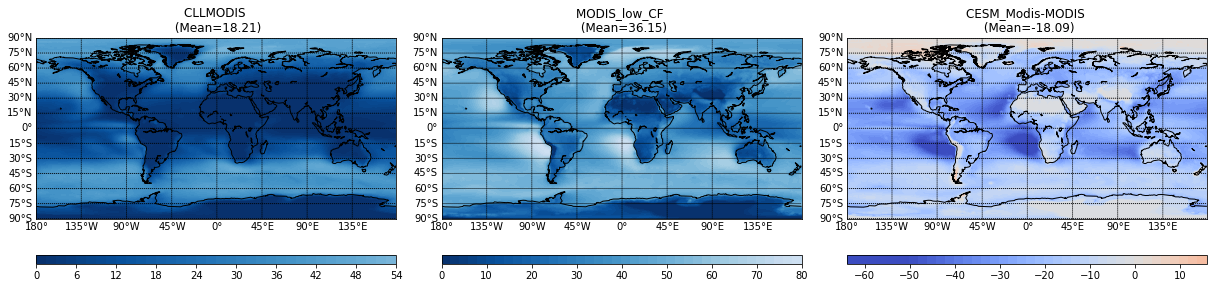

/umbc/xfs1/cybertrn/common/Softwares/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'cbar_kwargs'
  s)


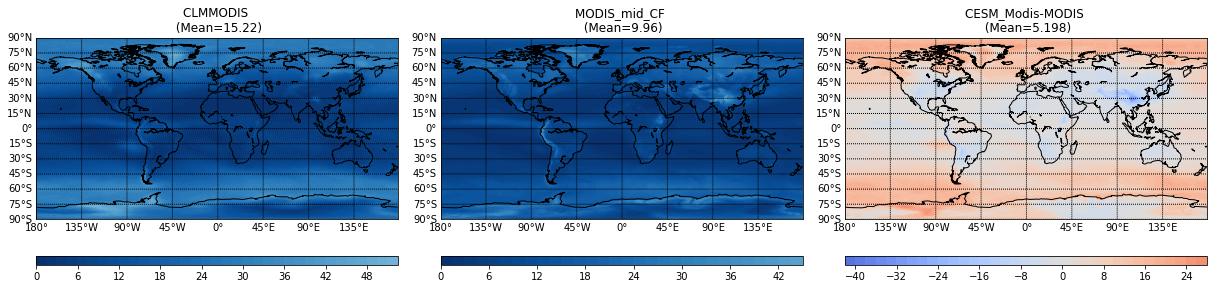

/umbc/xfs1/cybertrn/common/Softwares/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'cbar_kwargs'
  s)


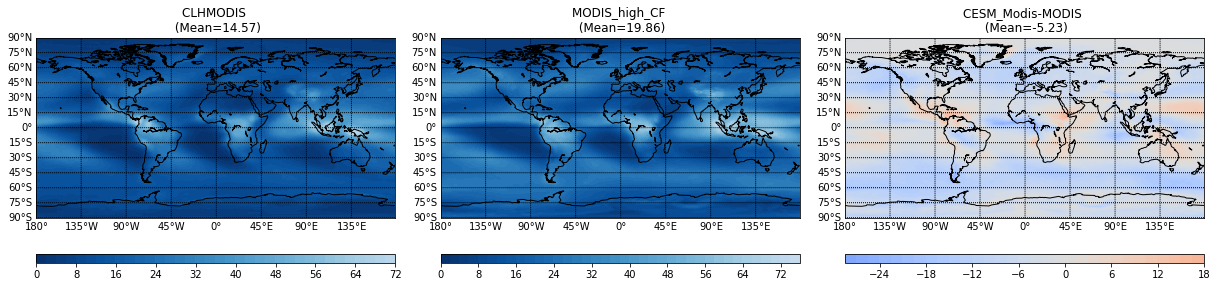

In [11]:
lonout, latout = np.meshgrid(lons,lats)

# Low CF

plt.figure(figsize=(17,13))
plt.subplot(131)
plot_2D_global(CLLMODIS_data.lons+180,CLLMODIS_data.lats,np.roll(CLLMODIS_mean,144,axis=1), data_name = 'CLLMODIS \n (Mean=%.4g)' %np.mean(np.roll(CLLMODIS_mean,144,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(132)
plot_2D_global(lons+180,lats,np.flipud(MODIS_low_CF*100), data_name = 'MODIS_low_CF \n (Mean=%.4g)' %np.mean(np.flipud(MODIS_low_CF*100)), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(133)
CLDLOW_interp = basemap.interp(np.roll(CLDLOW_mean*100,144,axis=1),CLDLOW_data.lons, CLDLOW_data.lats, lonout, latout,checkbounds=False, masked=False, order=1)
CLLMODIS_interp = basemap.interp(np.roll(CLLMODIS_mean,144,axis=1),CLLMODIS_data.lons, CLLMODIS_data.lats, lonout, latout,checkbounds=False, masked=False, order=1)
plot_2D_global(lons+180,lats,(CLLMODIS_interp-np.flipud(MODIS_low_CF*100)), data_name = 'CESM_Modis-MODIS \n (Mean=%.4g)' %np.mean(CLLMODIS_interp-np.flipud(MODIS_low_CF*100)), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
#plot_2D_global(lons,lats,(CLLMODIS_interp-np.flipud(MODIS_low_CF*100)), data_name = 'CESM-MODIS(Mean=%.4g)' %np.mean(CLLMODIS_interp-np.flipud(MODIS_low_CF*100)), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
#plt.savefig('./Results/New/Global maps/Clouds/MODIS Total cloud fraction.png')
plt.tight_layout()
plt.show()

# Mid CF

plt.figure(figsize=(17,13))
plt.subplot(131)
plot_2D_global(CLMMODIS_data.lons+180,CLMMODIS_data.lats,np.roll(CLMMODIS_mean,144,axis=1), data_name = 'CLMMODIS \n (Mean=%.4g)' %np.mean(np.roll(CLMMODIS_mean,144,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(132)
plot_2D_global(lons+180,lats,np.flipud(MODIS_mid_CF*100), data_name = 'MODIS_mid_CF \n (Mean=%.4g)' %np.mean(np.flipud(MODIS_mid_CF*100)), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(133)
CLDMED_interp = basemap.interp(np.roll(CLDMED_mean*100,144,axis=1),CLDMED_data.lons, CLDMED_data.lats, lonout, latout,checkbounds=False, masked=False, order=1)
CLMMODIS_interp = basemap.interp(np.roll(CLMMODIS_mean,144,axis=1),CLMMODIS_data.lons, CLMMODIS_data.lats, lonout, latout, checkbounds=False, masked=False, order=1)
plot_2D_global(lons+180,lats,(CLMMODIS_interp-np.flipud(MODIS_mid_CF*100)), data_name = 'CESM_Modis-MODIS \n (Mean=%.4g)' %np.mean(CLMMODIS_interp-np.flipud(MODIS_mid_CF*100)), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
#plt.savefig('./Results/New/Global maps/Clouds/MODIS Total cloud fraction.png')
plt.tight_layout()
plt.show()

# High CF

plt.figure(figsize=(17,13))
plt.subplot(131)
plot_2D_global(CLHMODIS_data.lons+180,CLHMODIS_data.lats,np.roll(CLHMODIS_mean,144,axis=1), data_name = 'CLHMODIS \n (Mean=%.4g)' %np.mean(np.roll(CLHMODIS_mean,144,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(132)
plot_2D_global(lons+180,lats,np.flipud(MODIS_high_CF*100), data_name = 'MODIS_high_CF \n (Mean=%.4g)' %np.mean(np.flipud(MODIS_high_CF*100)), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(133)
CLDHGH_interp = basemap.interp(np.roll(CLDHGH_mean*100,144,axis=1),CLDHGH_data.lons, CLDHGH_data.lats, lonout, latout,checkbounds=False, masked=False, order=1)
CLHMODIS_interp = basemap.interp(np.roll(CLHMODIS_mean,144,axis=1),CLHMODIS_data.lons, CLHMODIS_data.lats, lonout, latout, checkbounds=False, masked=False, order=1)
plot_2D_global(lons+180,lats,(CLHMODIS_interp-np.flipud(MODIS_high_CF*100)), data_name = 'CESM_Modis-MODIS \n (Mean=%.4g)' %np.mean(CLHMODIS_interp-np.flipud(MODIS_high_CF*100)), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
#plt.savefig('./Results/New/Global maps/Clouds/MODIS Total cloud fraction.png')
plt.tight_layout()
plt.show()

## Cloud radiative effect vs low cloud fraction

In [12]:
tropical_CLLMODIS_interp = []
tropical_MODIS_low_CF = []
tropical_CLDLOW_CAL_interp = []
tropical_CLDLOW_interp = []
tropical_CLMMODIS_interp = []
tropical_MODIS_mid_CF = []
tropical_CLDMED_CAL_interp = []
tropical_CLDMED_interp = []
tropical_CLHMODIS_interp = []
tropical_MODIS_high_CF = []
tropical_CLDHGH_CAL_interp = []
tropical_CLDHGH_interp = []

def tropical(low_CF,mid_CF,high_CF,lat_i,lat_f,lon_i,lon_f,lim):
    new_low_CF = low_CF[lat_i:lat_f,lon_i:lon_f]
    new_mid_CF = mid_CF[lat_i:lat_f,lon_i:lon_f]
    new_high_CF = high_CF[lat_i:lat_f,lon_i:lon_f]
    regional_low_CF = np.zeros((len(new_low_CF),len(new_low_CF[0])))
    
    for i in range(len(new_low_CF)):
        for j in range(len(new_low_CF[0])):
            if (new_mid_CF[i,j]<lim and new_high_CF[i,j]<lim or new_mid_CF[i,j]==None or new_high_CF[i,j]==None):
                regional_low_CF[i,j] = new_low_CF[i,j]
            else:
                regional_low_CF[i,j]=None
    return regional_low_CF

#Tropical region

tropical_CLLMODIS_interp = tropical(CLLMODIS_interp,CLMMODIS_interp,CLHMODIS_interp,60,121,0,361,10)
tropical_CLDLOW_interp = tropical(CLDLOW_interp,CLDMED_interp,CLDHGH_interp,60,121,0,361,10)
tropical_MODIS_low_CF = tropical(np.flipud(MODIS_low_CF*100),np.flipud(MODIS_mid_CF*100),np.flipud(MODIS_high_CF*100),60,121,0,361,10)

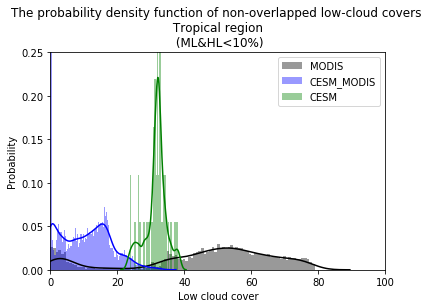

In [13]:
ax1 = sns.distplot(tropical_MODIS_low_CF[~np.isnan(tropical_MODIS_low_CF)], bins=100, color='black',label="MODIS")
ax2 = sns.distplot(tropical_CLLMODIS_interp[~np.isnan(tropical_CLLMODIS_interp)], bins=100, color='blue',label="CESM_MODIS")
ax3 = sns.distplot(tropical_CLDLOW_interp[~np.isnan(tropical_CLDLOW_interp)], bins=100, color='green',label="CESM")
plt.legend()
ax1.set_ylim(0,0.25)
ax1.set_xlim(0,100)
ax1.set(xlabel='Low cloud cover', ylabel='Probability')
plt.title('The probability density function of non-overlapped low-cloud covers \n Tropical region \n (ML&HL<10%)')
plt.show()

In [14]:
# Cloud radiative effect = Net cloudy - Net clear

def CRE(data_type,net_cloudy_sky,net_clear_sky,regional_lowcloud_interp,lat_i,lat_f,lon_i,lon_f):
    CRE = net_cloudy_sky-net_clear_sky
    if data_type=='model':
        CRE_interp = basemap.interp(np.roll(CRE,144,axis=1),CLLMODIS_data.lons, CLLMODIS_data.lats, lonout, latout,checkbounds=False, masked=False, order=1)
    elif data_type=='obs':
        CRE_interp = CRE
    regional_CRE = CRE_interp[lat_i:lat_f,lon_i:lon_f]
    
    CF_bins = np.linspace(np.nanmin(regional_lowcloud_interp),np.nanmax(regional_lowcloud_interp),10)
    CRE_bins = np.zeros(len(CF_bins))
    
    for k in range(1,len(CF_bins)):
        m=0
        for i in range(len(regional_CRE)):
            for j in range(len(regional_CRE[0])):
                if CF_bins[k-1]<=regional_lowcloud_interp[i,j]<=CF_bins[k]:
                    m +=1
                    CRE_bins[k] += (regional_CRE[i,j])/m
                    
    return CF_bins,CRE_bins


#CRE when weighted by CF

def CRE_cfw(data_type,net_cloudy_sky,net_clear_sky,regional_lowcloud_interp,lat_i,lat_f,lon_i,lon_f):
    CRE = net_cloudy_sky-net_clear_sky
    if data_type=='model':
        CRE_interp = basemap.interp(np.roll(CRE,144,axis=1),CLLMODIS_data.lons, CLLMODIS_data.lats, lonout, latout,checkbounds=False, masked=False, order=1)
    elif data_type=='obs':
        CRE_interp = CRE
    regional_CRE = CRE_interp[lat_i:lat_f,lon_i:lon_f]
    
    CF_bins = np.linspace(np.nanmin(regional_lowcloud_interp),np.nanmax(regional_lowcloud_interp),10)
    CRE_bins = np.zeros(len(CF_bins))
    
    for k in range(1,len(CF_bins)):
        m=0
        for i in range(len(regional_CRE)):
            for j in range(len(regional_CRE[0])):
                if CF_bins[k-1]<=regional_lowcloud_interp[i,j]<=CF_bins[k]:
                    m +=1
                    CRE_bins[k] += (regional_CRE[i,j]*regional_lowcloud_interp[i,j]/100)/m
                    
    return CF_bins,CRE_bins


tropical_CF_bins_cesmmodis,tropical_CRE_bins_cesmmodis = CRE('model',FSNTOA_mean,FSNTOAC_mean,tropical_CLLMODIS_interp,60,121,0,361)
tropical_CF_bins_obs,tropical_CRE_bins_obs = CRE('obs',net_sw_toa,net_sw_toa_clr,tropical_MODIS_low_CF,60,121,0,361)
tropical_CF_bins_cesmmodiscfw,tropical_CRE_bins_cesmmodiscfw = CRE_cfw('model',FSNTOA_mean,FSNTOAC_mean,tropical_CLLMODIS_interp,60,121,0,361)
tropical_CF_bins_obscfw,tropical_CRE_bins_obscfw = CRE_cfw('obs',net_sw_toa,net_sw_toa_clr,tropical_MODIS_low_CF,60,121,0,361)

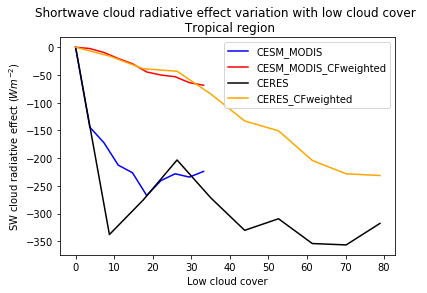

In [15]:
#tropical CRE with low cloud cover

plt.plot(tropical_CF_bins_cesmmodis,tropical_CRE_bins_cesmmodis,label='CESM_MODIS',color='blue')
plt.plot(tropical_CF_bins_cesmmodiscfw,tropical_CRE_bins_cesmmodiscfw,label='CESM_MODIS_CFweighted',color='red')
plt.plot(tropical_CF_bins_obs,tropical_CRE_bins_obs,label='CERES',color='black')
plt.plot(tropical_CF_bins_obscfw,tropical_CRE_bins_obscfw,label='CERES_CFweighted',color='orange')
plt.legend()
plt.title('Shortwave cloud radiative effect variation with low cloud cover \n Tropical region')
plt.xlabel('Low cloud cover')
plt.ylabel('SW cloud radiative effect ($Wm^{-2}$)')
plt.show()